<a target="_blank" href="https://colab.research.google.com/github/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/blob/main/05_sequence_models/01_training_sequence_model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Prerequisites**

To run the notebook locally you need `tensorflow`, `scipy`, `sklearn`, `numpy`, `pandas`, `matplotlib`, and `seaborn` installed. 

If you run it via google colab everything should already be there and you can continue.

In [ ]:
from IPython.display import clear_output


---

# 2. How to train a Deep Learning model?  - Hands-on

---

In this tutorial, we will show you how to:

> 1. Train a Convolutional Neural Network (CNN) on MPRA data  
> 2. Evaluate models


# STEP 1

## Getting a deep neural network (DNN) model

---

> For example, how about DeepSTARR? From *Almeida et al., 2022*

> They have also a github repository with all their code: [DeepSTARR](https://github.com/bernardo-de-almeida/DeepSTARR)


## Importing libraries

---

In [1]:
# DNN libraries
import tensorflow as tf
import keras
import keras.layers as kl
from keras.callbacks import EarlyStopping, History

# Data-analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# For reproducibility
import random
random.seed(42)

2025-05-19 09:37:30.126103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 09:37:30.513401: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# STEP 2


## The Data - Getting MPRA dataset

Here, we will use a dataset from the following study:

*Agarwal, V., Inoue, F., Schubach, M., Martin, B.K., Dash, P.M., Zhang, Z., Sohota, A., Noble, W.S., Yardimci, G.G., Kircher, M. and Shendure, J., 2023. **Massively parallel characterization of transcriptional regulatory elements in three diverse human cell types**. bioRxiv.*

---

In [2]:
%%bash
mkdir -p 01_data

if [ ! -f "01_data/ultra_k562_full.tsv.gz" ]; then
    wget -O 01_data/ultra_k562_full.tsv.gz https://github.com/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/raw/refs/heads/main/05_sequence_models/01_data/ultra_k562_full.tsv.gz
else
    echo "File exists"
fi

File exists


In [3]:
# Reading a .tsv file
data = pd.read_csv('01_data/ultra_k562_full.tsv.gz', sep='\t')
data.head()

,name,sequence,log2.1,log2.2,log2.3,log2.mean
0,BCL11A_1,AGGACCGGATCAACTTAAATGACTTCAACTGCCCCAACCCCTCTTC...,-0.642,-0.269,-0.514,-0.475
1,BCL11A_2,AGGACCGGATCAACTTGGGCAACAGGGCAAAGCCCCATCTCCCGAA...,-0.315,-0.859,-0.520,-0.564
2,BCL11A_3,AGGACCGGATCAACTAAAAGAAAAAAGGAAACATAAAACCAAACAT...,-0.854,-0.657,-0.870,-0.794
3,BCL11A_6,AGGACCGGATCAACTGGAGGAGAGAGGAAAGGAGAAGTCAATAGGG...,-0.022,-0.710,-0.615,-0.449
4,BCL11A_8,AGGACCGGATCAACTCTATTTCCTTCAGTTCTGCTCTGATTTTAGT...,-0.696,-0.781,-0.206,-0.561


## Understanding data distribution

---

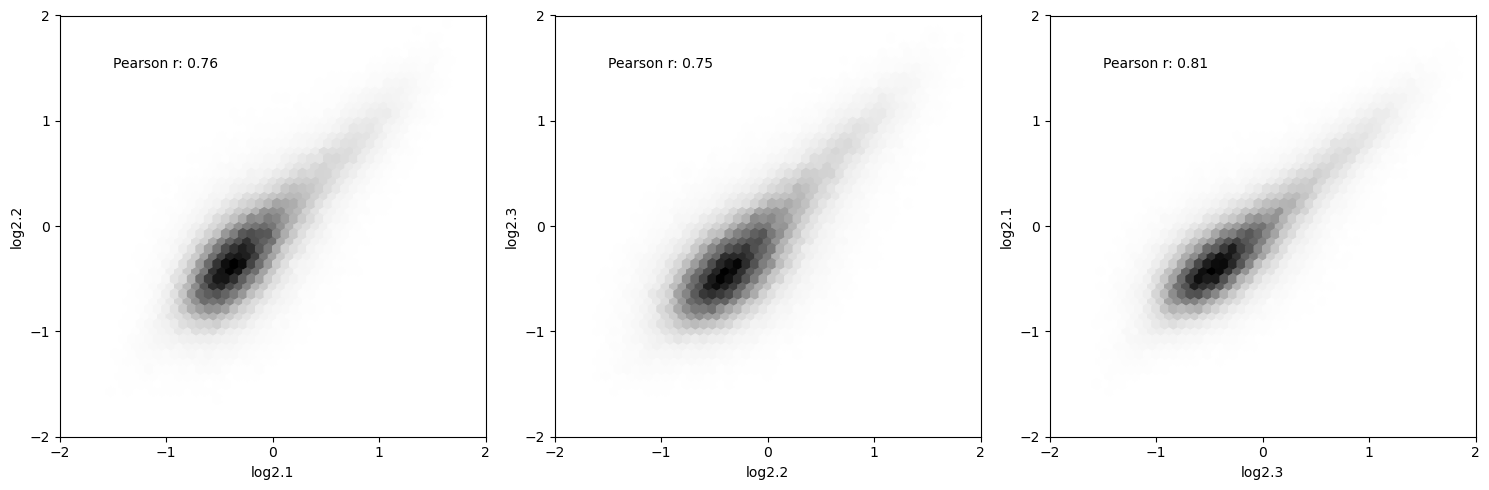

In [4]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, (col1, col2) in enumerate([(2, 3), (3, 4), (4, 2)]):
    # Create a hexbin plot for the joint plot
    hb = axes[i].hexbin(data.iloc[:, col1], data.iloc[:, col2], gridsize=50, extent=[-2, 2, -2, 2], cmap='Greys')

    # Calculate and print the Pearson correlation coefficient and p-value
    corr_coef, p_value = stats.pearsonr(data.iloc[:, col1], data.iloc[:, col2])
    axes[i].text(-1.5, 1.5, f'Pearson r: {corr_coef:.2f}')

    # Set the same axes limits for all subplots
    axes[i].set_xlim([-2, 2])
    axes[i].set_ylim([-2, 2])

    # Set the axis labels
    axes[i].set_xlabel(data.columns[col1])
    axes[i].set_ylabel(data.columns[col2])

    # Set ticks in axis per each integer
    axes[i].set_xticks(np.arange(-2, 3, 1))
    axes[i].set_yticks(np.arange(-2, 3, 1))

plt.tight_layout()
plt.show()

## One-hot encoding

Let's understand how to one-hot encode a DNA sequence.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs00449-022-02716-w/MediaObjects/449_2022_2716_Fig3_HTML.png?as=webp" alt="STARR-seq data" width="600"/>

[Reference](https://link.springer.com/article/10.1007/s00449-022-02716-w)

---

Are there only 4 DNA/RNA nucleotide base annotations?  
> Of course not :)

| IUPAC nucleotide code | Base                |
| --------------------- | ------------------- |
| A                     | Adenine             |
| C                     | Cytosine            |
| G                     | Guanine             |
| T (or U)              | Thymine (or Uracil) |
| R                     | A or G              |
| Y                     | C or T              |
| S                     | G or C              |
| W                     | A or T              |
| K                     | G or T              |
| M                     | A or C              |
| B                     | C or G or T         |
| D                     | A or G or T         |
| H                     | A or C or T         |
| V                     | A or C or G         |
| N                     | any base            |

[Source](https://www.bioinformatics.org/sms/iupac.html)

In [5]:
# Define a dictionary to map nucleotides to their one-hot encoded representation
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # What if there's an N?

# Define a function to one-hot encode a single DNA sequence
def one_hot_encode(seq):
    return np.array([nucleotide_dict[nuc] for nuc in seq])

## Train, test and validation split

---

Let's split the dataset as follows:
  - Input X: sequences as one-hot encoded
  - Output Y: mean MPRA activity (`log2.mean`)
  - Split:
    - 90% train
    - 5% test
    - 5% validation

In [6]:
def splitEncode(df, X_cols, y_cols):
    # Split the dataframe into X and y
    X = df[X_cols]
    y = df[y_cols]

    # One-hot encode the X data
    X = np.array(X['sequence'].apply(one_hot_encode).tolist())

    # Split the data into train and test+validation sets (90% and 10%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)

    # Split the test+validation sets into test and validation sets (50% and 50% of 10% => 5% and 5% of total)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [7]:
# Let's split
X_train, X_test, X_val, y_train, y_test, y_val = splitEncode(data, ['sequence'], ['log2.mean'])
pd.DataFrame({
    'Dataset': ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val'],
    'Shape': [X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape]
})

,Dataset,Shape
0,X_train,"(202099, 230, 4)"
1,X_test,"(11228, 230, 4)"
2,X_val,"(11228, 230, 4)"
3,y_train,"(202099, 1)"
4,y_test,"(11228, 1)"
5,y_val,"(11228, 1)"


## Setting hyperparameters

Here, we are going to use an optimized set of `params` (aka hyperparameters or model features) from the DeepSTARR study.

**Note: Importance of hyperparameters**
  - **Importance:** They define the model structure and learning process, significantly influencing performance.
  - **Achievement:** Set before training, determined by trial and error, or systematic search processes.
  - **Time:** Tuning hyperparameters is time-consuming as each configuration requires training a new model. Plan accordingly.

In [ ]:
params = {'batch_size': 64, # number of examples per batch
          'epochs': 10, # number of epochs
          'early_stop': 10, # patience of 10 epochs to reduce training time; you can increase the patience to see if the model improves after more epochs
          'lr': 0.001, # learning rate
          'n_conv_layer': 3, # number of convolutional layers
          'num_filters1': 128, # number of filters/kernels in the first conv layer
          'num_filters2': 60, # number of filters/kernels in the second conv layer
          'num_filters3': 60, # number of filters/kernels in the third conv layer
          # 'num_filters4': 120,
          'kernel_size1': 7, # size of the filters in the first conv layer
          'kernel_size2': 3, # size of the filters in the second conv layer
          'kernel_size3': 5, # size of the filters in the third conv layer
          # 'kernel_size4': 3,
          'n_dense_layer': 1, # number of dense/fully connected layers
          'dense_neurons1': 64, # number of neurons in the dense layer
          # 'dense_neurons2': 256,
          'dropout_conv': 'yes', # add dropout after convolutional layers?
          'dropout_prob': 0.4, # dropout probability
          'pad': 'same'}

## Model configuration - Setting input and output

We will follow the DeepSTARR model structure. 

In the original DeepSTARR work, they used the Spearman correlation as additional metric using this code:

```python
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32),
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )
```

Since Keras 3.0 y_true and y_pred are keras tesonsors and not numpy arrays. Therefore functions like `.shape` which are used by `spearmanr` will not work. Theerfore we implement the Pearson correlation by our self:

In [9]:
from keras import backend as K

def spearman_correlation(y_true, y_pred):
    # Flatten in case of shape (batch, 1)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    # Compute ranks
    y_true_rank = tf.argsort(tf.argsort(y_true))
    y_pred_rank = tf.argsort(tf.argsort(y_pred))
    # Cast to float32 for correlation calculation
    y_true_rank = tf.cast(y_true_rank, tf.float32)
    y_pred_rank = tf.cast(y_pred_rank, tf.float32)
    # Subtract mean
    y_true_rank -= tf.reduce_mean(y_true_rank)
    y_pred_rank -= tf.reduce_mean(y_pred_rank)
    # Calculate numerator and denominator for Pearson correlation of ranks
    numerator = tf.reduce_sum(y_true_rank * y_pred_rank)
    denominator = tf.sqrt(tf.reduce_sum(tf.square(y_true_rank)) * tf.reduce_sum(tf.square(y_pred_rank)))
    return numerator / (denominator + K.epsilon())

Now the class of the DeepSTARR model. Inputs, layers, etc. are controlled via the pre-defined parameters.

In [10]:
def DeepSTARR(params):

    lr = params['lr']
    # expects sequences of length 230 with 4 channels, length of DNA sequences
    input = kl.Input(shape=(230, 4))

    # Body - 4 conv + batch normalization + ReLU activation + max pooling
    # The number of convolutional layers and their hyperparameters are determined by the values in the params dictionary.
    x = kl.Conv1D(params['num_filters1'], kernel_size=params['kernel_size1'],
                  padding=params['pad'],
                  name='Conv1D_1')(input)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('relu')(x)
    x = kl.MaxPooling1D(2)(x)

    for i in range(1, params['n_conv_layer']):
        x = kl.Conv1D(params['num_filters'+str(i+1)],
                      kernel_size=params['kernel_size'+str(i+1)],
                      padding=params['pad'],
                      name=str('Conv1D_'+str(i+1)))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.MaxPooling1D(2)(x)
        # add dropout after convolutional layers?
        if params['dropout_conv'] == 'yes': x = kl.Dropout(params['dropout_prob'])(x)

    # After the convolutional layers, the output is flattened and passed through a series of fully connected/dense layers
    # Flattening converts a multi-dimensional input (from the convolutions) into a one-dimensional array (to be connected with the fully connected layers
    x = kl.Flatten()(x)

    # Fully connected layers
    # Each fully connected layer is followed by batch normalization, ReLU activation, and dropout
    for i in range(0, params['n_dense_layer']):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.Dropout(params['dropout_prob'])(x)

    # Main model bottleneck
    bottleneck = x

    # heads per task (developmental and housekeeping enhancer activities)
    tasks = ['log2.mean']
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='linear', name=str('Dense_' + task))(bottleneck))

    model = keras.models.Model([input], outputs)
    model.compile(keras.optimizers.Adam(learning_rate=lr),
                  loss=['mse'], # loss
                  loss_weights=[1], # loss weights to balance
                  metrics=[spearman_correlation]) # additional track metric

    return model, params

DeepSTARR(params)[0].summary()

2025-05-19 09:38:07.164056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 230, 4)]          0         
                                                                 
 Conv1D_1 (Conv1D)           (None, 230, 128)          3712      
                                                                 
 batch_normalization (BatchN  (None, 230, 128)         512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 230, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 115, 128)         0         
 )                                                               
                                                                 
 Conv1D_2 (Conv1D)           (None, 115, 60)           23100 

# STEP 3

---

## Training a DNN

Now, we are ready to start model training.

In [11]:
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):

    my_history=selected_model.fit(X_train, Y_train,
                                  validation_data=(X_valid, Y_valid),
                                  batch_size=params['batch_size'], epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True),
                                             History()])

    return selected_model, my_history

main_model, main_params = DeepSTARR(params)
main_model, my_history = train(main_model, X_train, y_train, X_val, y_val, main_params)

Epoch 1/3
3158/3158 [==============================] - 252s 79ms/step - loss: 0.2815 - spearman_correlation: 0.2735 - val_loss: 0.2267 - val_spearman_correlation: 0.4228
Epoch 2/3
3158/3158 [==============================] - 237s 75ms/step - loss: 0.2067 - spearman_correlation: 0.4496 - val_loss: 0.1957 - val_spearman_correlation: 0.5293
Epoch 3/3
3158/3158 [==============================] - 273s 86ms/step - loss: 0.1824 - spearman_correlation: 0.5237 - val_loss: 0.1999 - val_spearman_correlation: 0.5015


## Things to remember

---

# STEP 4

---

## Model evaluation

It's time to evaluate our model.
  - Did it **PASS**, **FAIL**, or is it the **BEST**!

### Understand training

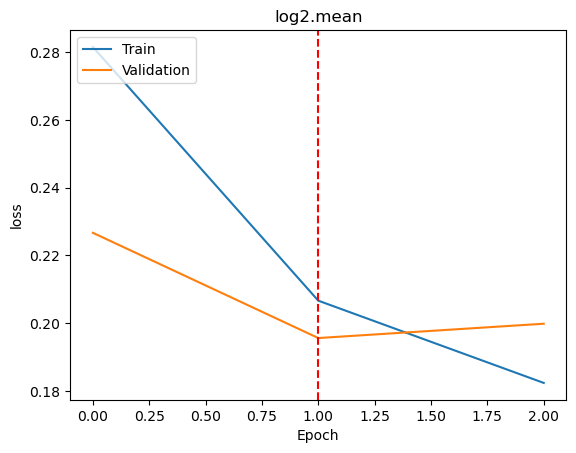

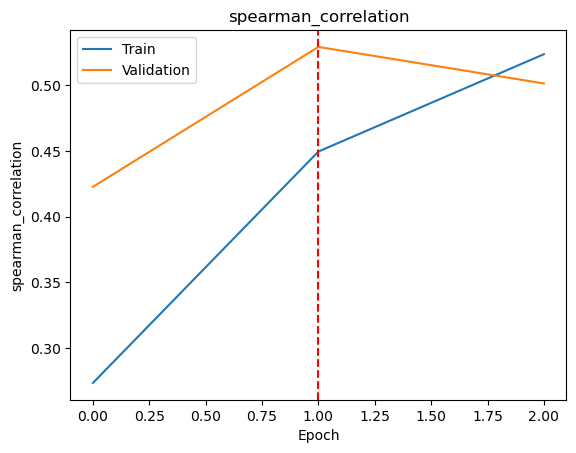

In [13]:
# Plot training & validation metrics
def plot_metrics(history, metric_name, title=None, vertical_line_func=min):
    plt.plot(history[metric_name])
    plt.plot(history['val_' + metric_name])
    if not title:
        title = metric_name
    plt.title(title)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Add vertical line at minimum/maximum validation loss or spearman correlation
    min_val_loss = vertical_line_func(history['val_' + metric_name])
    plt.axvline(x=history['val_' + metric_name].index(min_val_loss), color='red', linestyle='--')

    plt.show()

# MSE
plot_metrics(my_history.history, 'loss', title='log2.mean')
# Spearman
plot_metrics(my_history.history, 'spearman_correlation', vertical_line_func=max)

### Performance metrics

In [14]:
def evaluate_model(X, y, model):
    # Predict the output
    y_pred = model.predict(X)
    # Reshape the arrays to be one-dimensional
    y = y.values.reshape(-1)
    y_pred = y_pred.reshape(-1)

    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    pcc, _ = pearsonr(y, y_pred)
    scc, _ = spearmanr(y, y_pred)

    # Create a DataFrame for the table
    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'PCC', 'SCC'],
        'Value': [mse, pcc, scc]
    })

    # Print the table
    print(metrics_df)

In [15]:
evaluate_model(X_val, y_val, main_model)

351/351 [==============================] - 3s 7ms/step
  Metric     Value
0    MSE  0.199879
1    PCC  0.557078
2    SCC  0.506279


In [16]:
evaluate_model(X_test, y_test, main_model)

351/351 [==============================] - 4s 10ms/step
  Metric     Value
0    MSE  0.188579
1    PCC  0.577383
2    SCC  0.530568


### Plotting data - A model perspective

176/176 [==============================] - 4s 20ms/step


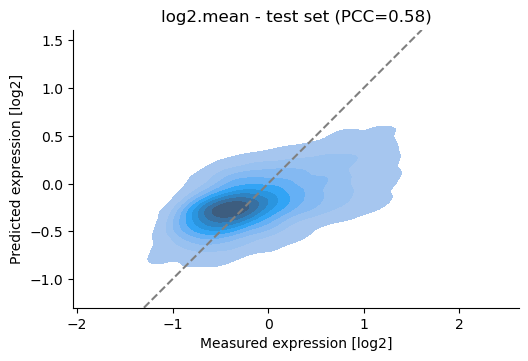

In [17]:
# Smooth scatter plot - useful when there are thousands of points

# Takes some time to calculate the kernel density
def my_scatter_density(X, Y, set, task):
  pred = main_model.predict(X, batch_size=main_params['batch_size'])

  # Convert DataFrames to numpy arrays and reshape to be one-dimensional
  Y = Y.values.reshape(-1)
  pred = pred.reshape(-1)

  g = sns.jointplot(x=Y, y=pred, kind="kde", fill=True)
  g.ax_marg_x.remove() # remove marginal densities
  g.ax_marg_y.remove() # remove marginal densities

  # Add expected regression line
  x0, x1 = g.ax_joint.get_xlim()
  y0, y1 = g.ax_joint.get_ylim()
  lims = [max(x0, y0), min(x1, y1)]
  g.ax_joint.plot(lims, lims, linestyle='dashed', color='grey')

  # Same axes ranges
  g.ax_joint.set_aspect('equal')

  PCC = str("{0:0.2f}".format(stats.pearsonr(Y, pred)[0]))
  plt.xlabel('Measured expression [log2]')
  plt.ylabel('Predicted expression [log2]')
  plt.title(str(task + ' - ' + set + ' set (PCC=' + PCC + ')'))

  plt.show()

# Print plots for test sets
my_scatter_density(X_test, y_test, "test", "log2.mean")

# Saving your model

---

In [19]:
# Save your model weights and structure as it is
main_model.save('01_data/my_DeepSTARR_model.h5')